<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave-Sentence-Embedding-Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA

In [2]:
%pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0102f42ecff4b905ef86e962cab7f4a6d4048c68f890b19c55f9baf2b9e50363
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=abd4196ac0522d66903daaf4f4e341c67aba15a56ed95fb99d41358497bf53b4
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
# train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)

In [10]:
train.shape

(375092, 11)

In [11]:
sample_df = train.groupby('label').apply(lambda x: x.sample(50000, random_state=99))

In [12]:
sample_df.label.value_counts()

0    50000
1    50000
Name: label, dtype: int64

In [13]:
nlp = spacy.load("en_core_web_sm")

In [14]:
sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])

In [15]:
sample_df.iloc[0]['embedding']

array([ 0.01823193,  0.4154876 ,  0.7377034 , -0.2962893 , -0.23702231,
       -0.06604573, -0.61949396, -0.4244492 ,  0.44684976,  0.2585516 ,
        0.29039913, -0.13762945, -0.12475292, -0.3482426 ,  0.08243544,
       -0.01295885, -0.07908605,  0.09828032, -0.07869907, -0.02076909,
        0.09553783, -0.10050287,  0.01984699,  0.7526506 ,  0.02659307,
        0.08573489, -0.0826791 , -0.23625156, -0.40657672,  0.1541268 ,
        0.12819819,  0.38742313, -0.72350156, -0.6194456 ,  0.31610247,
        0.10758962, -0.4342197 ,  0.25259185, -0.165194  ,  0.18970971,
        0.5759415 ,  0.47506452, -0.2081238 , -0.44306523,  0.15650329,
       -0.07555199,  0.33519742,  0.5402867 , -0.25004014, -0.2961595 ,
        0.46286035, -0.1706211 , -0.05973683, -0.2041003 , -0.24140687,
        0.09916173,  0.46397457, -0.03801919, -0.07418916, -0.10266594,
       -0.2281745 , -0.2670276 , -0.05990433, -0.28467005, -0.08412062,
       -0.74748075,  0.4396693 , -0.0462025 , -0.1711617 , -0.18

In [16]:
# My gridsearch-ish attempt at running k-means.  This routine will
# create a dictionary containing the cluster numbers, scores and 
# saves the best model found (as identified by score)

def find_best_kmeans(X,n_clus_lst):
 
  m = {'cluster':[],
       'score':[],
       'best_model':None}

  for idx, n in enumerate(n_clus_lst):
    km = KMeans(n_clusters=n,max_iter=500,
                random_state=99)
    km.fit(X)
    score = silhouette_score(X,km.labels_,
                    random_state=99)
    m['cluster'].append(n)
    if m['best_model'] == None:
      m['best_model'] = km
    elif score > np.max(m['score']):
      m['best_model'] = km    
    m['score'].append(score)
    
  return m


def plot_clusters(feature_one, feature_two, labels,title):
  # routine to plot out the clusters
  plt.figure(figsize=(10,10))
  plt.title(title)
  plt.xlabel("PCA Feature 1")
  plt.ylabel("PCA Feature 2")
  sns.scatterplot(x=feature_one,
                  y=feature_two,
                  hue=labels,
                  alpha=.3,
                  );

In [18]:
# old code
# X_std = StandardScaler().fit_transform(X)
# X_pca = PCA(n_components=5).fit_transform(X_std)

In [19]:

# Create a preprocessing pipeline for Clustering
preprocessor = Pipeline([('scaler', StandardScaler()),
                         ('pca', PCA(n_components=5))])


In [20]:
import seaborn as sns

Best Score: 0.6129518151283264


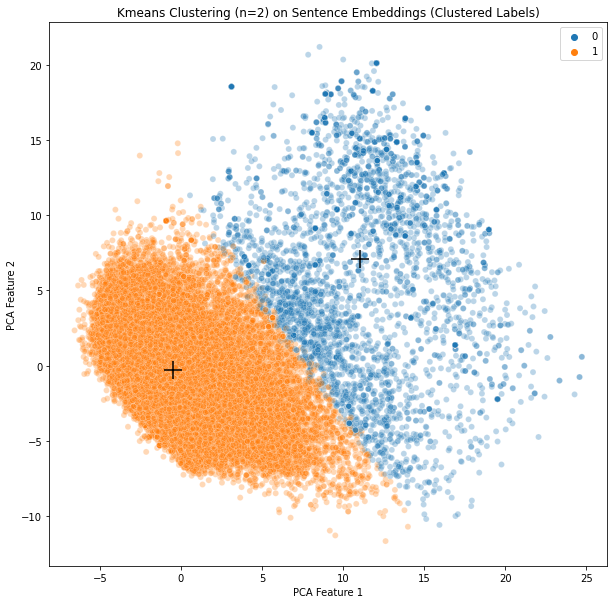

In [21]:
X_pca = preprocessor.fit_transform(X)
results = find_best_kmeans(X_pca, [x for x in range(2,10)])
print(f"Best Score: {np.max(results['score'])}")
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Clustered Labels)"
plot_clusters(feat_one,
              feat_two,
              km.labels_, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)


In [22]:
# k-means found cluster separation however, the Silo score is around .5, 
# which doesn't imply great clustering separation.
# The plus signs are the respective cluster centers. Looking at what 
# sentences are clustered close by the centers for additional information

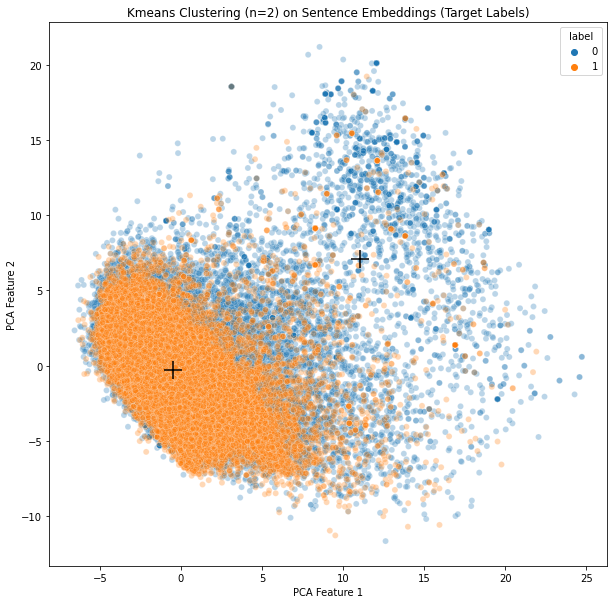

In [23]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [26]:
#code modified from https://stackoverflow.com/questions/69164379/how-to-find-the-index-of-the-point-closest-to-k-means-cluster-centers-using-skle
from scipy.spatial.distance import euclidean

def top_sentences_by_cluster(X,km,df):
  closest_pt_idx = []
  for iclust in range(km.n_clusters):
      # get all points assigned to each cluster:
      cluster_pts = X[km.labels_ == iclust]
      # get all indices of points assigned to this cluster:
      cluster_pts_indices = np.where(km.labels_ == iclust)[0]

      cluster_cen = km.cluster_centers_[iclust]
      top = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[:10]
      bottom = np.argsort([euclidean(X[idx], cluster_cen) for idx in cluster_pts_indices])[-10:]

      print(" ")
      print(f" Cluster {iclust + 1}")
      print("--------------")
      # Print out the results for each cluster:
      print(f" ")
      print(f'top 10 closest sentences to cluster {iclust}\'s center:')
      for sent_vec in top:
        print(df.iloc[cluster_pts_indices[sent_vec]]['original_text'])
      print(" ")
      print(f'farthest sentences to cluster {iclust}\'s center:')
      for sent_vec in bottom[::-1]:
        print(df.iloc[cluster_pts_indices[sent_vec]]['original_text'])


In [27]:
top_sentences_by_cluster(X_pca,km,sample_df)

 
 Cluster 1
--------------
 
top 10 closest sentences to cluster 0's center:
Oldenburg
Wilmersdorf ;
Wilmersdorf ;
Toy
Image = Gray854 .
Image = Gray854 .
Image = Gray854 .
Discography
Discography
Discography
 
farthest sentences to cluster 0's center:
-3999
17.46
1991
2005
-1999
2007 .
2007 .
2007 .
101-103 .
1970\/71
 
 Cluster 2
--------------
 
top 10 closest sentences to cluster 1's center:
Year 20 -LRB- XX -RRB- was a leap year starting on Monday -LRB- link will display the full calendar -RRB- of the Julian calendar .
Judgment Day -LRB-/O2009/O-RRB- , a professional wrestling pay-per-view -LRB- PPV -RRB- event produced by World Wrestling Entertainment -LRB- WWE -RRB- , took place on May 17 , 2009 at the Allstate Arena in Rosemont , Illinois , a suburb of Chicago .
Year 1452 -LRB- MCDLII -RRB- was a leap year starting on Saturday -LRB- link will display the full calendar -RRB- of the Julian calendar .
By 1961 , Gordy had appointed Robinson vice-president of Motown Records , a tit

In [ ]:
# It appears the K-Means algorithm found clusters based on 
# sentence length for the sentence embeddings.  
# Cluster 2 appears to only have 1 word in the original text

NameError: ignored

In [31]:
sample_df[sample_df['original_text'].str.contains('1920 , 1921 , 1924 , 1925 , 1927 , 1936 , 1948 , 1961 , 1968')]

,,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label,embedding
label,ix,,,,,,,,,,,,
0,272854,"1920 , 1921 , 1924 , 1925 , 1927 , 1936 , 1948...",1920 1921 1924 1925 1927 1936 1948 1961 1968,16.2364,0.0,0.0,0.0,NaN,NaN,NaN,9.0,0,"[-0.5295936, 0.6763806, -0.5059674, -0.6923597..."


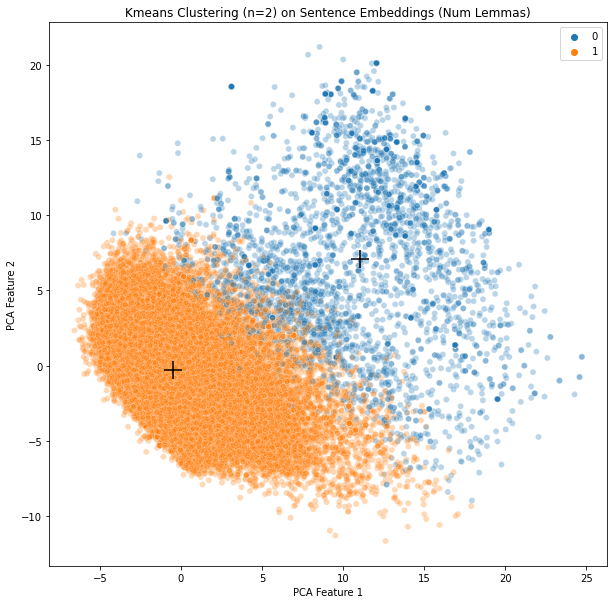

In [32]:
# Plotting using num_lemmas for color (1 is 3 or more lemmas, otherwise 0)

gt_one_lemma = [1 if x >= 3 else 0 for x in sample_df.num_lemmas]

plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Num Lemmas)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=gt_one_lemma,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [51]:
# quick calculation to get how many numbers are in each text for confirmation
sample_df['numbers'] = [len([y for y in x.split(' ') if y.isdigit()]) for x in sample_df.lemmatized_text]

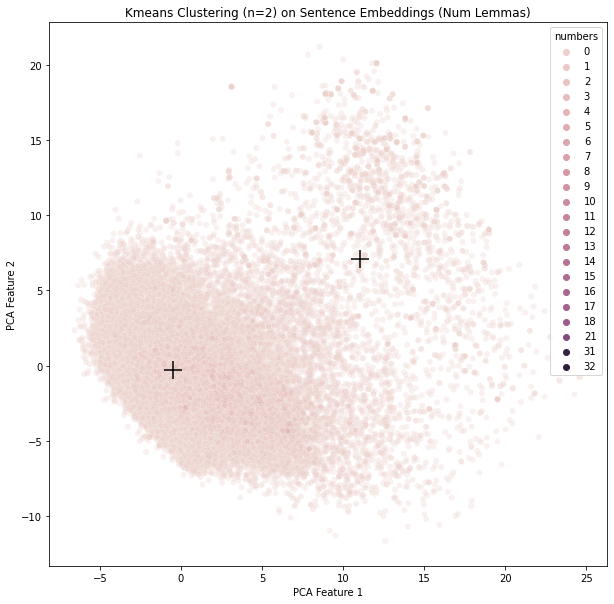

In [53]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Num Lemmas)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.numbers,
                alpha=.3,
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
sample_df['emb_member'] = km.labels_

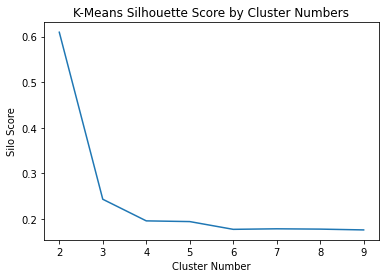

In [ ]:
plt.title("K-Means Silhouette Score by Cluster Numbers")
sns.lineplot(x=results['cluster'],
             y=results['score'])
plt.xlabel('Cluster Number')
plt.ylabel('Silo Score');

In [ ]:
def find_best_clusters_kpca_value(kernel):
  if kernel == "":
    kernel = 'linear'

  metrics = {'gamma': [],
            'clusters': [],
            'score': []
            }

  for g in [.001,.01,1, 10,100]:
    X_kpca = KernelPCA(n_components=5,
                       kernel=kernel,
                       gamma=g).fit_transform(X_std)
    results = find_best_kmeans(X_kpca, [x for x in range(2,10)])
    for idx, score in enumerate(results['score']):
      metrics['gamma'].append(g)
      metrics['clusters'].append(results['cluster'][idx])
      metrics['score'].append(score)

  return pd.DataFrame(metrics),metrics

In [ ]:
metrics_df,metrics = find_best_clusters_kpca_value('linear')
metrics_df.sort_values('score', ascending=False)[:5]

,gamma,clusters,score
8,0.010,2,0.609384
32,100.000,2,0.609384
0,0.001,2,0.609384
16,1.000,2,0.609384
24,10.000,2,0.609384


In [ ]:
metrics_df,metrics = find_best_clusters_kpca_value('rbf')
metrics_df.sort_values('score', ascending=False)[:5]

,gamma,clusters,score
36,100.0,6,0.999940
28,10.0,6,0.999940
20,1.0,6,0.999933
35,100.0,5,0.997894
27,10.0,5,0.997894


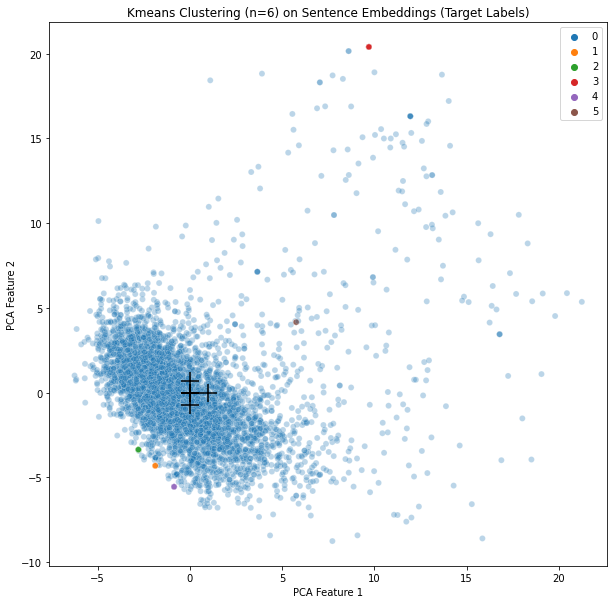

In [ ]:
X_kpca = KernelPCA(n_components=5, gamma=1, kernel='rbf').fit_transform(X_std)
results = find_best_kmeans(X_kpca, [x for x in range(2,10)])
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=km.labels_,
                alpha=.3,
                palette=sns.color_palette()[:km.n_clusters],
                legend='full')

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
# The K-Means Clustering with Kernel PCA Rbf function membership counts
np.bincount(km.labels_)

array([4960,    8,    7,   11,    8,    6])

In [ ]:
#!pip install ipympl

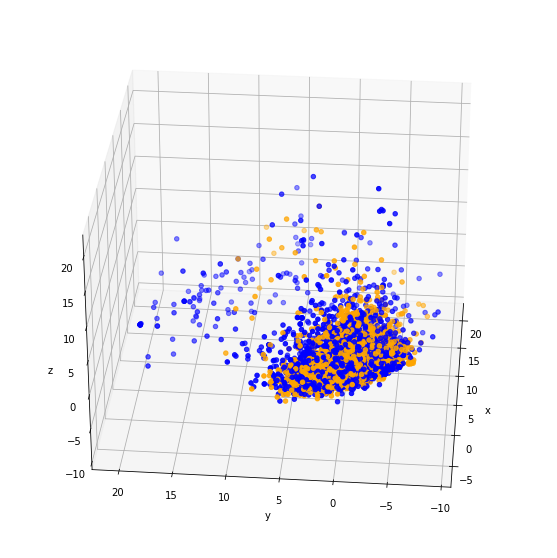

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# from mpl_toolkits import mplot3d
# %matplotlib widget

cmap = matplotlib.colors.ListedColormap(['blue', 'orange'])
plt.figure(figsize=(10,10))
axes = plt.axes(projection='3d')
axes.scatter3D(X_pca[:,0], X_pca[:,1],X_pca[:,2,],
               c=sample_df.label, cmap=cmap)

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')
axes.view_init(30, 185)
plt.show()



In [ ]:
import plotly.express as px


fig = px.scatter_3d(sample_df, x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
              color='label')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

fig.show()

# K-Means Clustering on Tfidf Vectorized Text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer( min_df=20,
                      ngram_range=(1,3)
                      )
X_vec = vec.fit_transform(sample_df['lemmatized_text'])
X_vec_PCA = PCA(n_components=5).fit_transform(X_vec.toarray())

In [ ]:
n_clust_lst = [x for x in range(2,11)]
tf_results = find_best_kmeans(X_vec_PCA,n_clust_lst)

In [ ]:
tf_results

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'score': [0.3502954557217614,
  0.39016667464732474,
  0.29140696914484326,
  0.3193035420582798,
  0.259653259061888,
  0.2577439650141051,
  0.26945999374966784,
  0.26970390452109744,
  0.2717220420851382],
 'best_model': KMeans(n_clusters=2, random_state=99)}

Best Score (tfidf): 0.6093838810920715


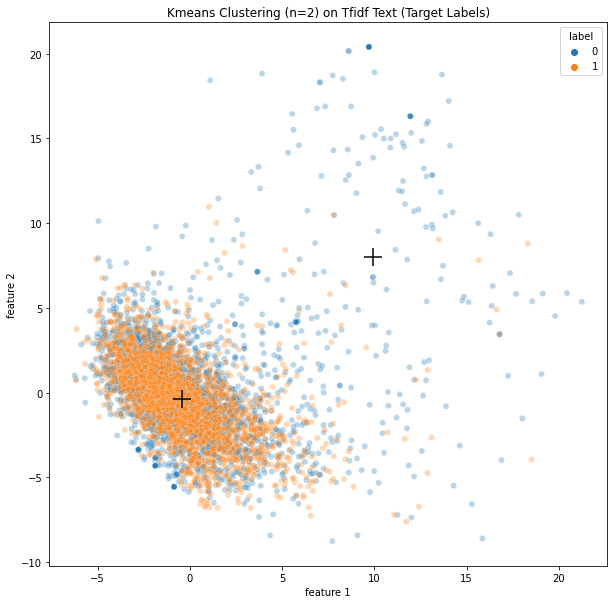

In [ ]:
print(f"Best Score (tfidf): {np.max(results['score'])}")
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Tfidf Text (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+", 
            color='black',s=300);

In [ ]:
top_sentences_by_cluster(X_vec_PCA,km,sample_df)

 
top 10 closest sentences to cluster 0's center:
Oxygen was independently discovered by Carl Wilhelm Scheele , in Uppsala , in 1773 or earlier , and Joseph Priestley in Wiltshire , in 1774 , but Priestley is often given priority because his publication came out in print first .
They obtained independence in 1960 .
After receiving a first prize in organ performance and improvisation in 1941 , Jeanne Demessieux studied five more years with Dupré in Meudon , before she played her début recital at Salle Pleyel in Paris in 1946 .
This happens at about 1 bit in 1015 in enterprise-class disk drives , and 1 bit in 1014 in ordinary disk drives .
This season was also the first to have a tiebreaker challenge : in , the person that had most votes against them in earlier Tribal Councils was voted out in such a situation , but in Samburus first tribal council , Carl Bilancione and Lindsey Richter each had four votes .
In The Brothers Karamazov , the character Dimitri Karamazov asks his atheist frie

# Numeric Features

In [ ]:
num_features = ['d_chall_score', 'aoa_mean',
       'aoa_min', 'aoa_max', 'conc_rating_mean', 'conc_rating_min',
       'conc_rating_max', 'num_lemmas']

In [ ]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = si.fit_transform(sample_df[num_features])
X_num_std = StandardScaler().fit_transform(X_num)


In [ ]:
metrics = find_best_kmeans(X_num_std,[2,3,4,5,6,7,8])

In [ ]:
metrics

{'cluster': [2, 3, 4, 5, 6, 7, 8],
 'score': [0.578215750326415,
  0.5827496800305163,
  0.1915945984651341,
  0.22061948770636472,
  0.2286004387003079,
  0.20774957793808052,
  0.19839061540106112],
 'best_model': KMeans(max_iter=500, n_clusters=3, random_state=99)}

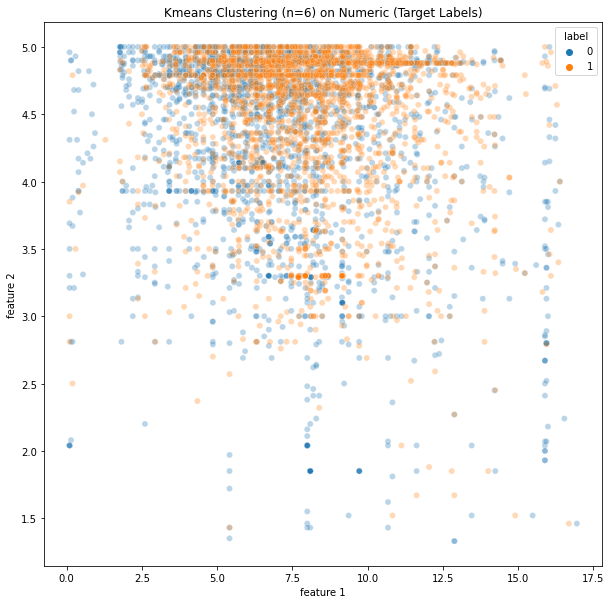

In [ ]:
c_labels = metrics['best_model'].labels_
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Numeric (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=sample_df['d_chall_score'],
                y=sample_df['conc_rating_max'],
                hue=sample_df.label,
                alpha=.3);


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Best Score: 0.5807250572847593


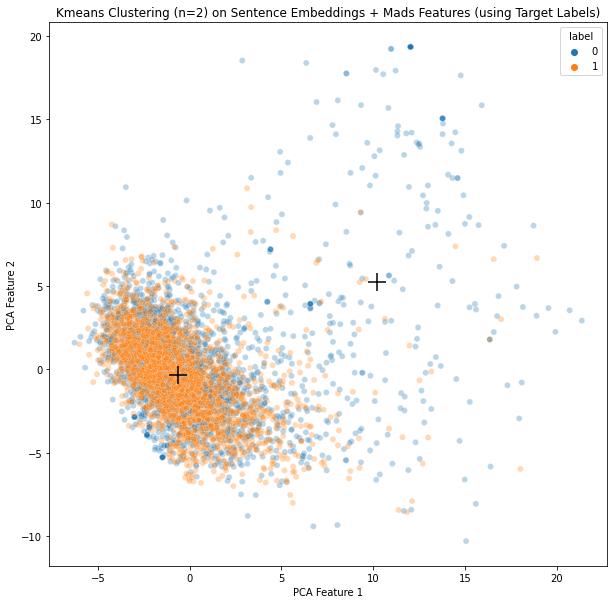

In [ ]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = si.fit_transform(sample_df[num_features])
X_num_std = StandardScaler().fit_transform(X_num)
num_df = pd.DataFrame(X_num_std, columns=num_features)


X_emb_mads = pd.concat([pd.DataFrame(X_std), num_df], axis=1)
X_em_std = StandardScaler().fit_transform(X_emb_mads)
X_em_pca = PCA(n_components=5).fit_transform(X_em_std)

results = find_best_kmeans(X_em_pca, [x for x in range(2,10)])
print(f"Best Score: {np.max(results['score'])}")
centers = np.array(results['best_model'].cluster_centers_)

km = results['best_model']
feat_one = X_em_pca[:,0]
feat_two = X_em_pca[:,1]
title = f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings + Mads Features (using Target Labels)"
plot_clusters(feat_one,
              feat_two,
              sample_df.label, title)

#plot cluster centers
plt.scatter(centers[:,0], centers[:,1], marker="+",
            color='black', s=300)


# Using UMAP For Dimensionality-Reduction

In [ ]:
import umap

In [ ]:
# Code obtained and slightly modified from https://umap-learn.readthedocs.io/en/latest/parameters.html

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    data=X_std
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)),c=data[:,0])
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data[:,0])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


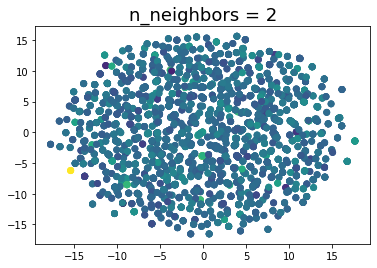

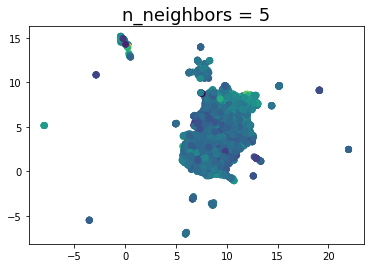

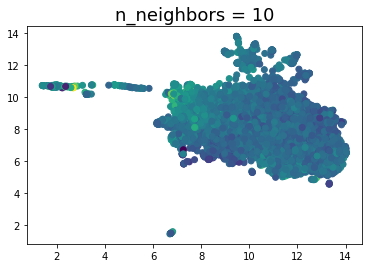

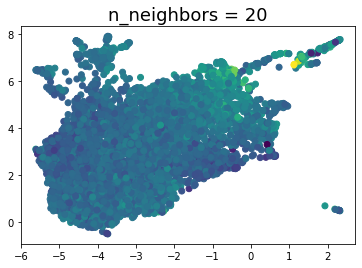

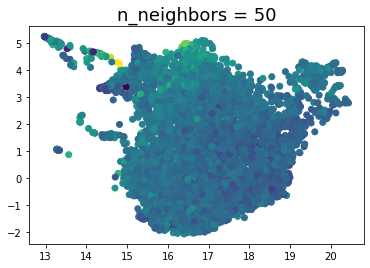

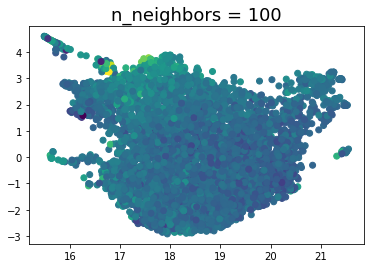

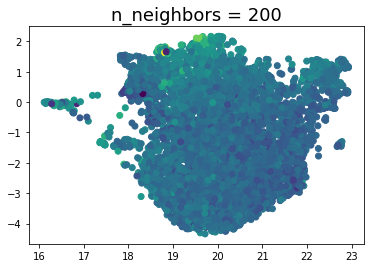

In [ ]:
# reducer = umap.UMAP(n_neighbors=5, n_components=2)
# embs = reducer.fit_transform(X_std)

for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [ ]:
# %pip install umap-learn
# %pip install "umap-learn[plot]"

In [ ]:
import umap.plot

Text(0.5, 1.0, 'Umap Results with Target Labels')

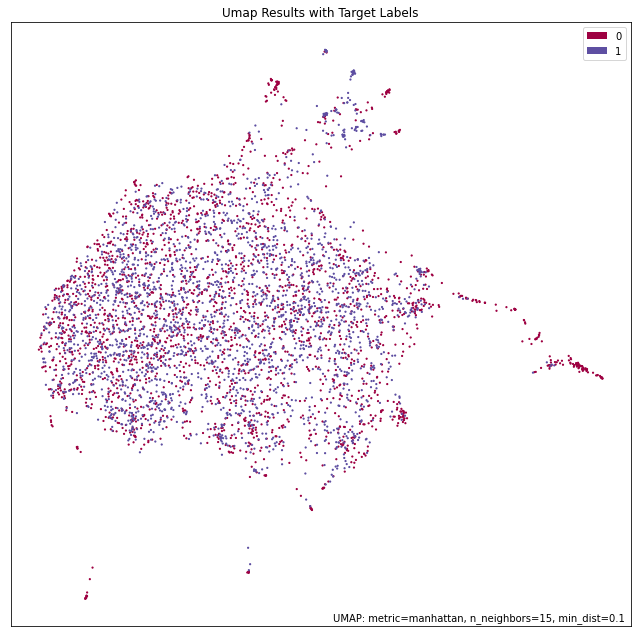

In [ ]:
mapper = umap.UMAP(metric='manhattan').fit(X_std)
umap.plot.points(mapper,labels=sample_df.label)
plt.title("Umap Results with Target Labels")

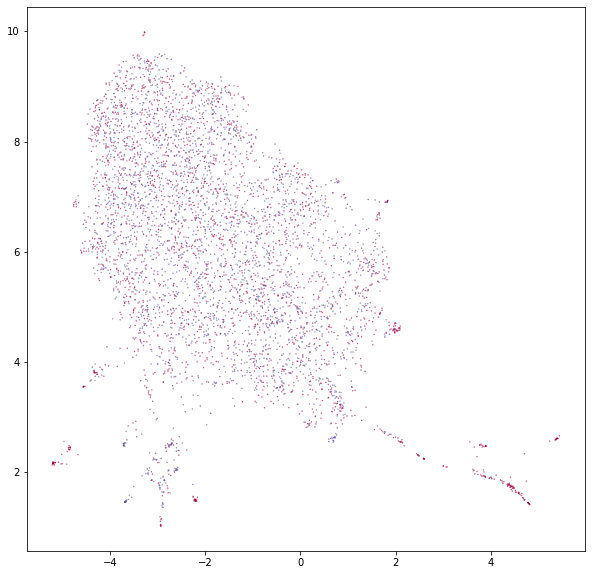

In [ ]:
standard_embedding = umap.UMAP(metric='euclidean',
                               random_state=99).fit_transform(X_std)
plt.figure(figsize=(10,10))
plt.scatter(standard_embedding[:, 0], 
            standard_embedding[:, 1],
            c=sample_df.label, s=0.1, cmap='Spectral')


In [ ]:
def find_best_clus_metric(lst_metrics):

  metrics = {'metric': [],
            'clusters': [],
            'score': []
            }

  clus_range = [x for x in range(2,10)]
  for m in lst_metrics:
    mapping = umap.UMAP(metric=m,
                                random_state=99).fit_transform(X_std)
    results = find_best_kmeans(mapping,clus_range)
    for idx, score in enumerate(results['score']):
      metrics['metric'].append(m)
      metrics['clusters'].append(results['cluster'][idx])
      metrics['score'].append(score)

  return metrics



lst_metrics = ['manhattan', 'euclidean','cosine','correlation']

metrics = find_best_clus_metric(lst_metrics)




In [ ]:
umap_res = pd.DataFrame(metrics)
umap_res.sort_values('score', ascending=False)[:5]

,metric,clusters,score
16,cosine,2,0.485775
24,correlation,2,0.480532
26,correlation,4,0.451779
18,cosine,4,0.444049
2,manhattan,4,0.431296


In [ ]:
# None of the kmeans scores using UMAP are better than what we were able to get through standard PCA
# The table above shows the 5 highest silo scores based on the metric passed to UMAP and the best clusters found
# found by k-means. Of the 4 measures used to derive dr, cosine and correlation measures
# produced the highest scores (top 4)

In [ ]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


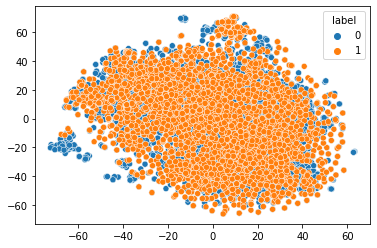

In [ ]:
for lr in [10,100,500,1000]:
  tsne= TSNE(learning_rate = lr,
             random_state=99,
             n_jobs=-1)
  X_tsne = tsne.fit_transform(X_std)
  
  
  
  sns.scatterplot(X_tsne[:,0],X_tsne[:,1], hue=sample_df['label'] )